# Compare ideal infomax filter with the retina's horizontal and amacrine cell projective fields

In [543]:
import numpy as np
from scipy.stats import sem

# import my functions
import info_theory_functions as info
from lnl_model_functions import *
from atick_redlich_functions import *
from get_davids_data import *
from image_processing_functions import *

# from scipy.optimize import minimize
# from scipy import fft, arange
# from random import randint
# from cmath import polar
# from numpy.fft import fft2
# from numpy.fft import fftshift
# from sklearn.decomposition import PCA
# from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import sem


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
# I recommend against enabling the whole notebook, since some plots come out funny.
# Instead, just use mpld3.display() at the end of cells you want to interact with.
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import natural images

In [2]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/Documents/Natural_Images/RawData/cd13A' # flood plain, water, horizon
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)

Only 78 files in directory.


In [3]:
allRot  = [spectrum2d(p,spacing=spacing,frequencyFlag=False) for p in patches]
specRot = mean(allRot, axis=0) # average out the amplitude spectrum over all images
frqRot, tmp = spectrum2d(patches[0],spacing=spacing,frequencyFlag=True)
error = [sem([allRot[j][i] for j in range(len(patches))]) for i in range(len(frqRot))]
originalSpectra = specRot
originalErrors  = error
originalFreqs   = frqRot

# Check if horizontal/vertical fft2 scale matches rotavg scale

In [12]:
patches_fft2 = [abs(np.fft.fft2(p))/np.prod(p.shape) for p in patches]
patches_horz = [np.mean(p, axis=0)[:p.shape[0]/2+1] for p in patches_fft2]
patches_vert = [np.mean(p, axis=1)[:p.shape[1]/2+1] for p in patches_fft2]

In [13]:
freqs_horz   = np.linspace(0, 1./(2.*(2./92)), len(patches_horz[0]))
freqs_vert   = np.linspace(0, 1./(2.*(2./92)), len(patches_vert[0]))

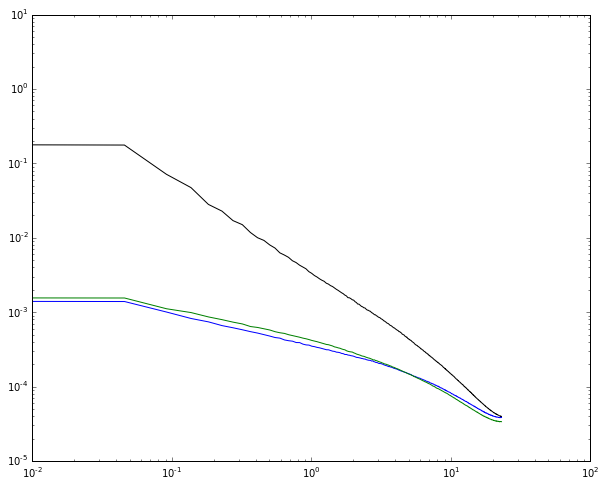

In [23]:
plot(originalFreqs, originalSpectra, 'k')
plot(freqs_horz, np.mean(patches_horz, axis=0), 'b')
plot(freqs_vert, np.mean(patches_vert, axis=0), 'g')
xscale('log')
yscale('log')

# Check different PCA modes (weight space by temporal PCA)

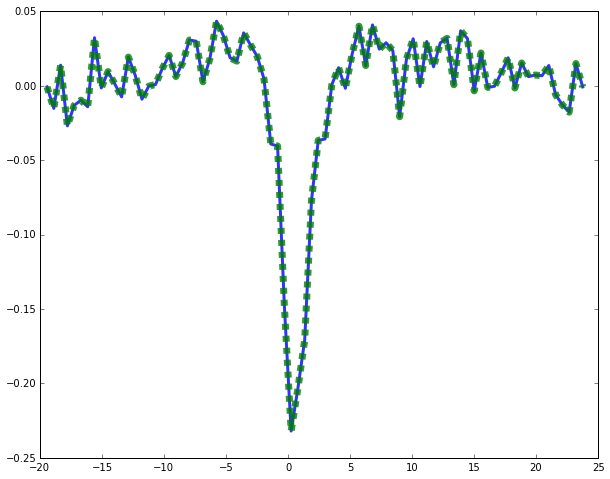

In [356]:
spatial_rfs_time  = load_ganglion_cells(pca_mode='time')
spatial_rfs_space = load_ganglion_cells(pca_mode='space')

plot(spatial_rfs_time[0][0], spatial_rfs_time[0][1], 'b', linewidth=3, alpha=0.8)
plot(spatial_rfs_space[0][0], spatial_rfs_time[0][1], 'g--', linewidth=7, alpha=0.8)

## So the two methods are identical

# Get the projective fields of horizontal and amacrine cells

In [338]:
microns_per_deg  = 50.
horz_spatial_pfs = get_horizontal_projective_field(micronsPerDeg=microns_per_deg)
horz_spatial_rfs = load_horizontal_cells(micronsPerDeg=microns_per_deg)
ama_spatial_pfs  = get_amacrine_projective_field(micronsPerDeg=microns_per_deg)
ama_spatial_rfs  = load_amacrine_cells(micronsPerDeg=microns_per_deg)

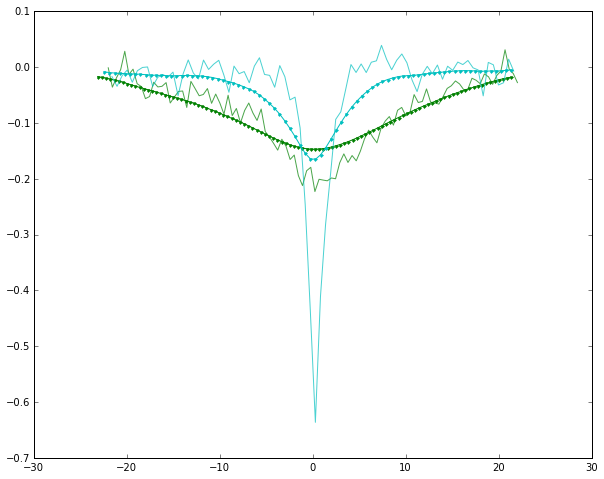

In [342]:
plot(horz_spatial_pfs[1][0], horz_spatial_pfs[1][1],'g.-')
plot(horz_spatial_rfs[1][0], horz_spatial_rfs[1][1],'g-', alpha=0.7)
plot(ama_spatial_pfs[0][0], ama_spatial_pfs[0][1],'c.-')
plot(ama_spatial_rfs[0][0], ama_spatial_rfs[0][1], 'c', alpha=0.7)

## Compare widths of horizontal and amacrine cells by fitting gaussians and comparing their standard deviations

#### Amacrine cell receptive field

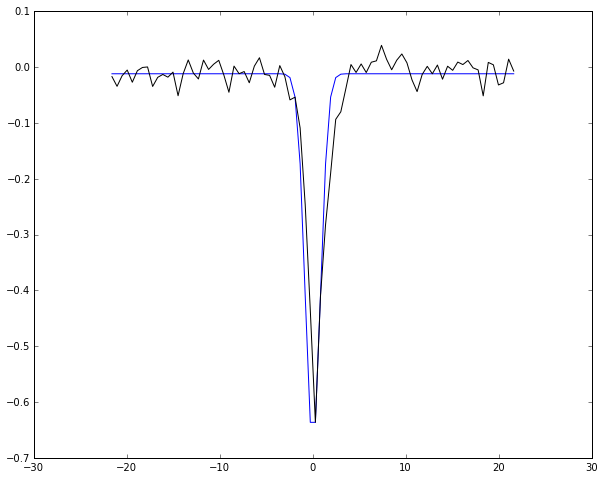

In [343]:
def fitGaussian(xs, stdev, dc, maxi=np.max(abs(ama_spatial_rfs[0][1]))):
    gauss = gaussian(x=xs, sigma=stdev, mu=0) + dc
    gauss *= -maxi/np.max(gauss)
    return gauss

# plot(ama_spatial_pfs[0][0], fitGaussian(ama_spatial_pfs[0][0], 3, 0.001), 'b')
# plot(ama_spatial_pfs[0][0], ama_spatial_pfs[0][1], 'k')

popt, pcov = curve_fit(fitGaussian, ama_spatial_rfs[0][0], ama_spatial_rfs[0][1], p0=[3, 0.001])
ama_rf_width = popt[0]

plot(ama_spatial_rfs[0][0], fitGaussian(ama_spatial_rfs[0][0], *popt), 'b')
plot(ama_spatial_rfs[0][0], ama_spatial_rfs[0][1], 'k')

#### Amacrine cell projective field

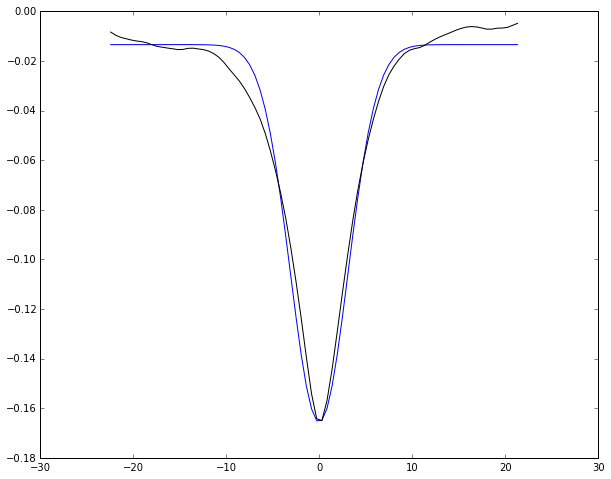

In [336]:
def fitGaussian(xs, stdev, dc, maxi=np.max(abs(ama_spatial_pfs[0][1]))):
    gauss = gaussian(x=xs, sigma=stdev, mu=0) + dc
    gauss *= -maxi/np.max(gauss)
    return gauss

# plot(ama_spatial_pfs[0][0], fitGaussian(ama_spatial_pfs[0][0], 3, 0.001), 'b')
# plot(ama_spatial_pfs[0][0], ama_spatial_pfs[0][1], 'k')

popt, pcov = curve_fit(fitGaussian, ama_spatial_pfs[0][0], ama_spatial_pfs[0][1], p0=[3, 0.001])
ama_pf_width = popt[0]

plot(ama_spatial_pfs[0][0], fitGaussian(ama_spatial_pfs[0][0], *popt), 'b')
plot(ama_spatial_pfs[0][0], ama_spatial_pfs[0][1], 'k')

#### Horizontal cell receptive field

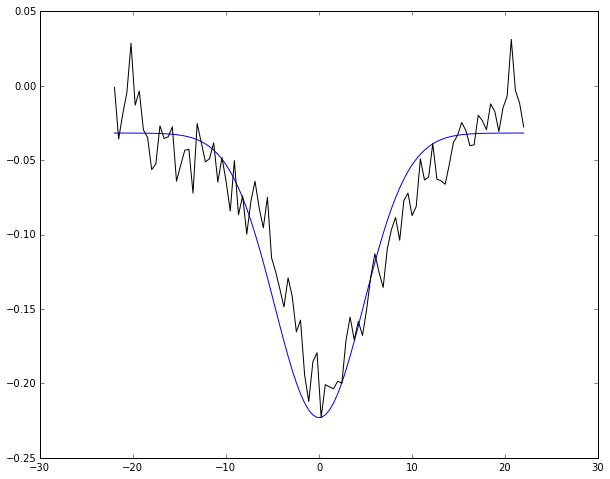

In [345]:
def fitGaussian(xs, stdev, dc, maxi=np.max(abs(horz_spatial_rfs[1][1]))):
    gauss = gaussian(x=xs, sigma=stdev, mu=0) + dc
    gauss *= -maxi/np.max(gauss)
    return gauss

# plot(ama_spatial_pfs[0][0], fitGaussian(ama_spatial_pfs[0][0], 3, 0.001), 'b')
# plot(ama_spatial_pfs[0][0], ama_spatial_pfs[0][1], 'k')

popt, pcov = curve_fit(fitGaussian, horz_spatial_rfs[1][0], horz_spatial_rfs[1][1], p0=[3, 0.001])
horz_rf_width = popt[0]

plot(horz_spatial_rfs[1][0], fitGaussian(horz_spatial_rfs[1][0], *popt), 'b')
plot(horz_spatial_rfs[1][0], horz_spatial_rfs[1][1], 'k')

#### Horizontal cell projective field

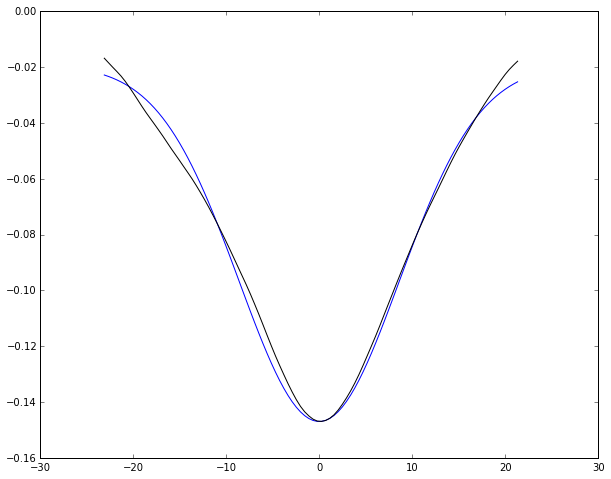

In [346]:
def fitGaussian(xs, stdev, dc, maxi=np.max(abs(horz_spatial_pfs[1][1]))):
    gauss = gaussian(x=xs, sigma=stdev, mu=0) + dc
    gauss *= -maxi/np.max(gauss)
    return gauss

# plot(ama_spatial_pfs[0][0], fitGaussian(ama_spatial_pfs[0][0], 3, 0.001), 'b')
# plot(ama_spatial_pfs[0][0], ama_spatial_pfs[0][1], 'k')

popt, pcov = curve_fit(fitGaussian, horz_spatial_pfs[1][0], horz_spatial_pfs[1][1], p0=[3, 0.001])
horz_pf_width = popt[0]

plot(horz_spatial_pfs[1][0], fitGaussian(horz_spatial_pfs[1][0], *popt), 'b')
plot(horz_spatial_pfs[1][0], horz_spatial_pfs[1][1], 'k')

## Compare horizontal and amacrine cell widths in receptive and projective fields

In [347]:
horz_rf_width/ama_rf_width

5.8650378759346866

In [348]:
horz_pf_width/ama_pf_width

2.7857469754095034

# Look at horizontal vs amacrine projective field ffts

In [55]:
horz_spatial_fft = get_horizontal_projective_fft()
ama_spatial_fft  = get_amacrine_projective_fft()

In [362]:
plot(horz_spatial_fft[1][0], horz_spatial_fft[1][1], 'g.-')
plot(ama_spatial_fft[0][0], ama_spatial_fft[0][1], 'c.-')
mpld3.display()

# Look at ganglion cell RFs

In [57]:
ganglion_spatial_rfs = load_ganglion_cells()

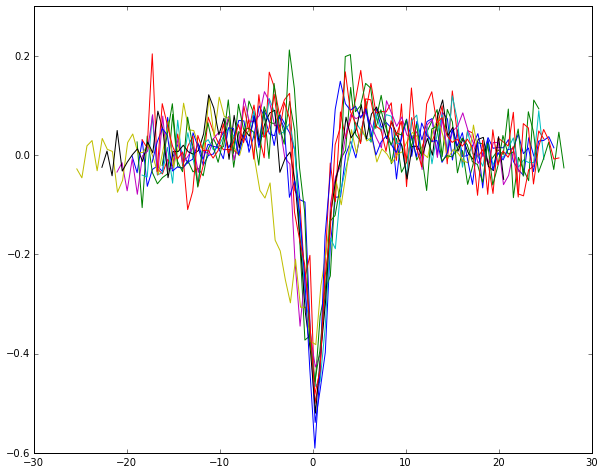

In [58]:
for cell in xrange(10):
    plot(ganglion_spatial_rfs[cell][0], ganglion_spatial_rfs[cell][1])

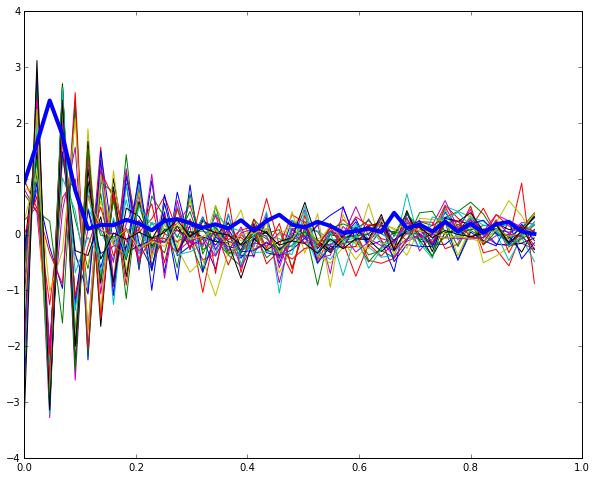

In [91]:
ganglion_ffts = get_fft(ganglion_spatial_rfs, mode='fourier')
for freq, ffti in ganglion_ffts:
    plot(freq, ffti)
plot(freq, abs(np.mean([ffti for _,ffti in ganglion_ffts], axis=0)), linewidth=4)
g_freqs    = freq
g_mean_fft = abs(np.mean([ffti for _,ffti in ganglion_ffts], axis=0))

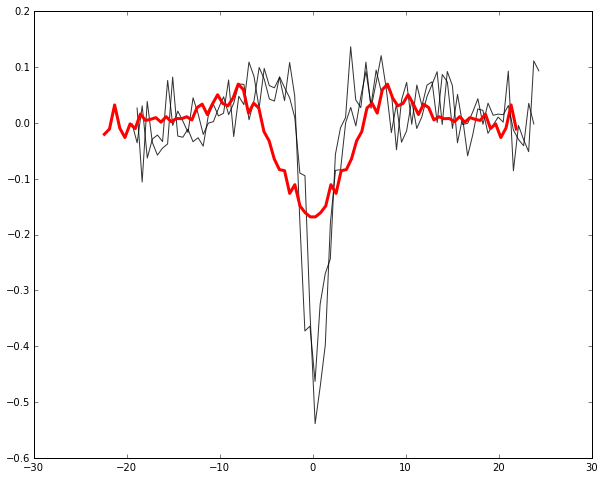

In [97]:
ganglion_rfs = load_ganglion_cells()
spatial_delta = ganglion_rfs[0][0][1] - ganglion_rfs[0][0][0]
plot(ganglion_rfs[0][0], ganglion_rfs[0][1], 'k', linewidth=1, alpha=0.8)
plot(ganglion_rfs[1][0], ganglion_rfs[1][1], 'k', linewidth=1, alpha=0.8)

g_fourier_mean    = np.mean([ffti for _,ffti in ganglion_ffts], axis=0)
g_fourier_mean_2s = np.hstack([g_fourier_mean, g_fourier_mean[1:][::-1]])
figment_ganglion_rf = np.fft.ifft(g_fourier_mean_2s)
figment_ganglion_space = get_space(figment_ganglion_rf, spatial_delta, microns_per_deg=50., scale=False)
plot(figment_ganglion_space, figment_ganglion_rf, 'r', linewidth=3)

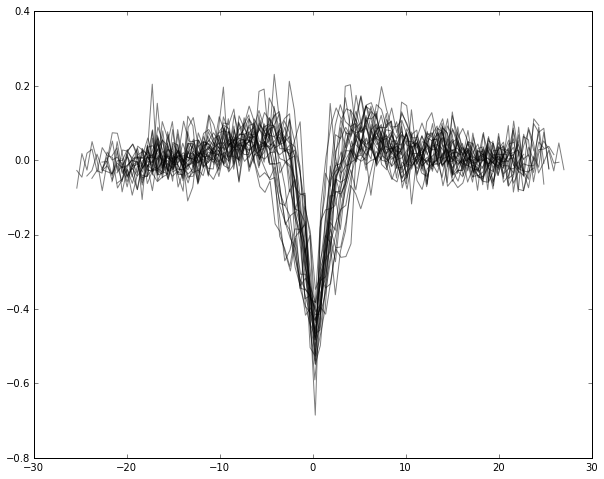

In [98]:
for f, rf in ganglion_rfs:
    plot(f, rf, 'k', alpha=0.5)

## Try clustering according to projection on PCA space

PCA(copy=True, n_components=3, whiten=False)

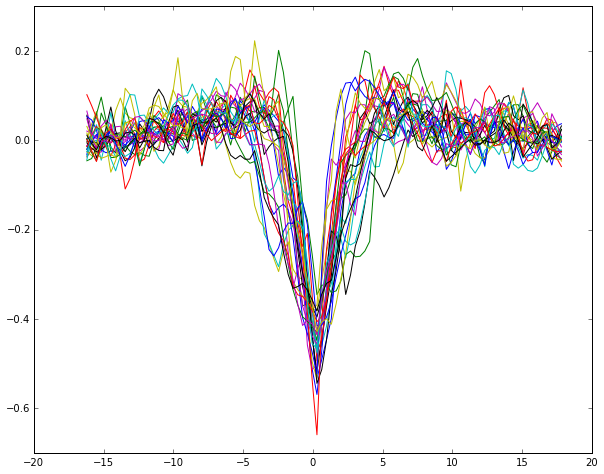

In [216]:
interp_ganglions     = get_interp(ganglion_rfs, nPoints = 100, mode='valid')
aligned_ganglion_rfs = np.vstack([y for x,y in interp_ganglions])
valid_space          = interp_ganglions[0][0]

plot(valid_space, aligned_ganglion_rfs.T)

pca = PCA(n_components=3)
pca.fit(aligned_ganglion_rfs)

In [138]:
pca.explained_variance_

array([ 0.09849361,  0.08718954,  0.03067587])

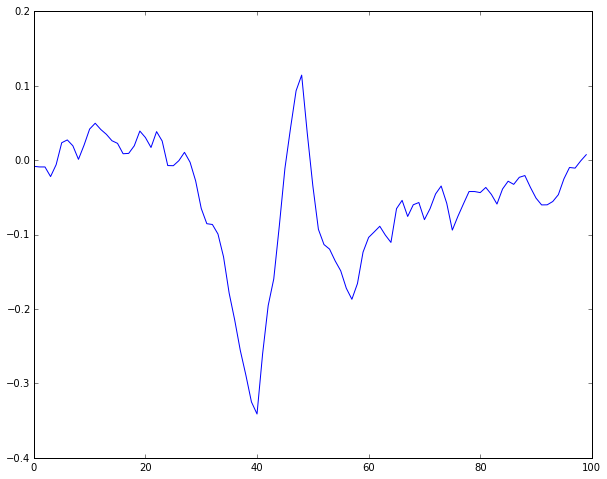

In [144]:
plot(pca.components_[0])

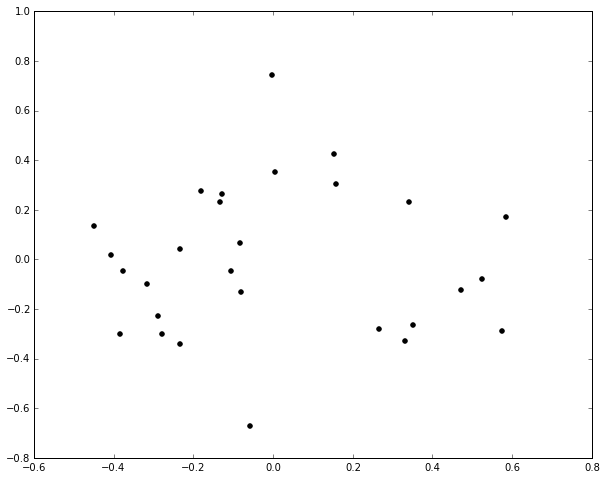

In [145]:
projection_pc1 = np.dot(aligned_ganglion_rfs, pca.components_[0])
projection_pc2 = np.dot(aligned_ganglion_rfs, pca.components_[1])
scatter(projection_pc1, projection_pc2, color='k')

## Cluster ganglion RFs by their width to the first positive number

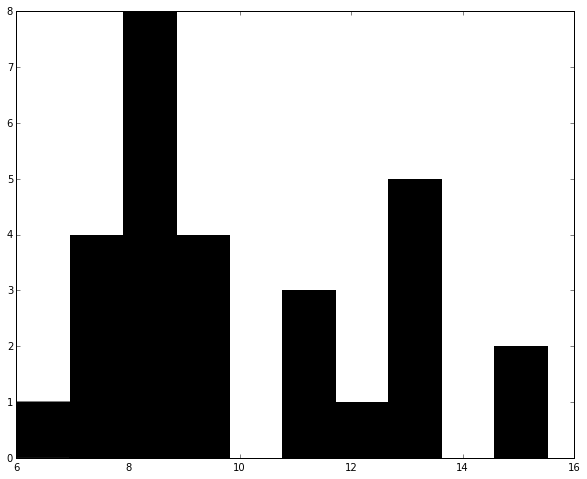

In [177]:
widths = []
for rf in aligned_ganglion_rfs:
    pos_inds = np.array([i for i in xrange(len(rf)) if rf[i] > 0])
    lefties  = 48 - pos_inds
    left_width  = np.min(lefties[lefties>=0])
    right_width = np.min(-lefties[lefties<0])
    #widths.append(np.min(abs(48 - pos_inds)))
    widths.append(np.mean([left_width, right_width]))
counts, bins, _ = hist(widths, color='k')

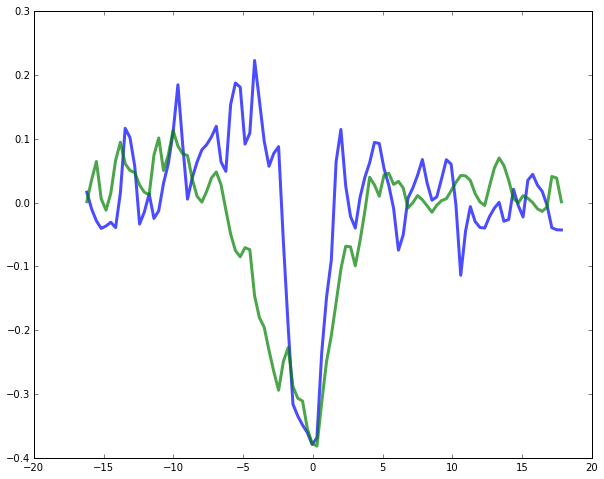

In [217]:
plot(valid_space, aligned_ganglion_rfs[np.argmin(widths)], 'b', linewidth=3, alpha=0.7)
plot(valid_space, aligned_ganglion_rfs[np.argmax(widths)], 'g', linewidth=3, alpha=0.7)

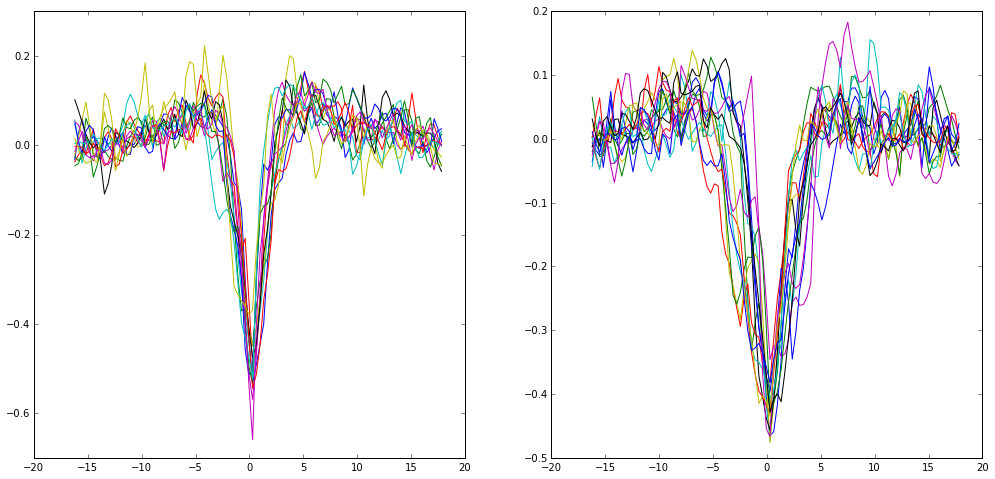

In [218]:
fig = gcf()
fig.set_size_inches((17,8))
subplot(1,2,1)
_ = plot(valid_space, aligned_ganglion_rfs[np.array(widths) < 9].T)
subplot(1,2,2)
_ = plot(valid_space, aligned_ganglion_rfs[np.array(widths) >= 9].T)

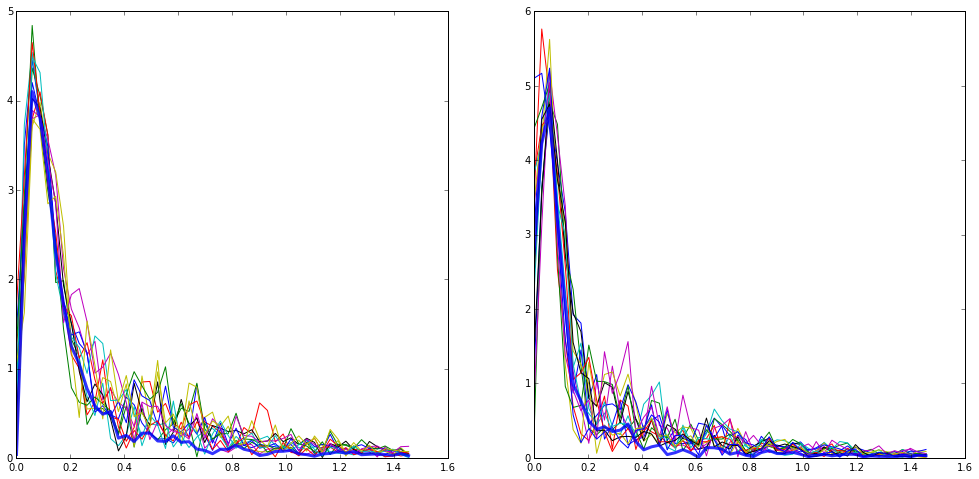

In [547]:
narrow_ganglions = aligned_ganglion_rfs[np.array(widths) < 9]
wide_ganglions   = aligned_ganglion_rfs[np.array(widths) >= 9]
narrow_ganglions_tuples = []
wide_ganglions_tuples   = []
for rf in xrange(narrow_ganglions.shape[0]):
    narrow_ganglions_tuples.append((valid_space, narrow_ganglions[rf]))
for rf in xrange(wide_ganglions.shape[0]):
    wide_ganglions_tuples.append((valid_space, wide_ganglions[rf]))
    
narrow_ganglions_ffts = get_fft(narrow_ganglions_tuples, mode='fourier')
wide_ganglions_ffts   = get_fft(wide_ganglions_tuples, mode='fourier')

fig = gcf()
fig.set_size_inches((17,8))
subplot(1,2,1)
for x,y in narrow_ganglions_ffts:
    plot(x,abs(y))
mean_narrow_ganglion_fft     = np.mean([y for x,y in narrow_ganglions_ffts], axis=0)
mean_narrow_ganglion_fft_err = sem([y for x,y in narrow_ganglions_ffts])
mean_narrow_freqs        = x
plot(x, abs(mean_narrow_ganglion_fft), 'b', linewidth=3, alpha=0.8)
# plot(x, abs(np.mean([abs(y) for x,y in narrow_ganglions_ffts], axis=0)), 'k', linewidth=3, alpha=0.8)
subplot(1,2,2)
for x,y in wide_ganglions_ffts:
    plot(x,abs(y))
mean_wide_ganglion_fft = np.mean([y for x,y in wide_ganglions_ffts], axis=0)
mean_wide_ganglion_fft_err = sem([y for x,y in wide_ganglions_ffts])
mean_wide_freqs        = x
plot(x, abs(mean_wide_ganglion_fft), 'b', linewidth=3, alpha=0.8)
# plot(x, abs(np.mean([abs(y) for x,y in wide_ganglions_ffts], axis=0)), 'k', linewidth=3, alpha=0.8)

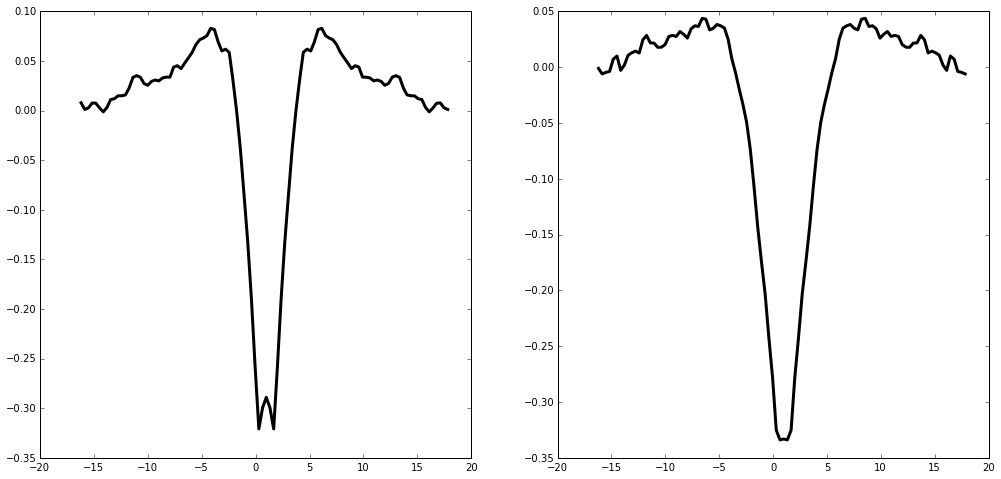

In [269]:
ifft_average_ganglion_narrow = np.fft.ifft(np.hstack([mean_narrow_ganglion_fft, mean_narrow_ganglion_fft[1:-1][::-1]]))
ifft_average_ganglion_wide   = np.fft.ifft(np.hstack([mean_wide_ganglion_fft, mean_wide_ganglion_fft[1:-1][::-1]]))

fig = gcf()
fig.set_size_inches((17,8))
subplot(1,2,1)
plot(valid_space, ifft_average_ganglion_narrow, 'k', linewidth=3)
subplot(1,2,2)
plot(valid_space, ifft_average_ganglion_wide, 'k', linewidth=3)

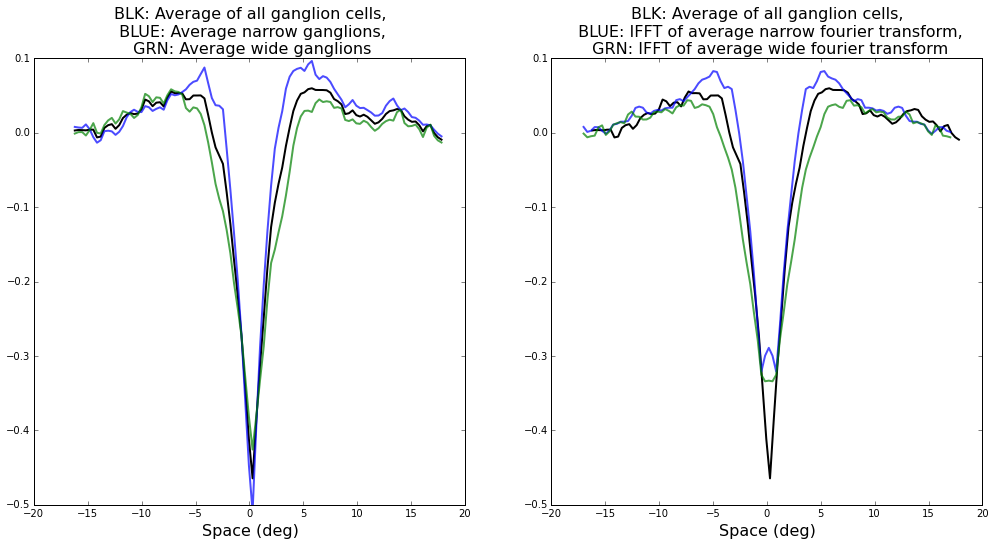

In [286]:
fig = gcf()
fig.set_size_inches((17,8))

subplot(1,2,1)
plot(valid_space, np.mean(aligned_ganglion_rfs, axis=0), 'k', linewidth=2)
plot(valid_space, np.mean(narrow_ganglions, axis=0), 'b', alpha=0.7, linewidth=2)
plot(valid_space, np.mean(wide_ganglions, axis=0), 'g', alpha=0.7, linewidth=2)
ylim([-0.5, 0.1])
xlabel('Space (deg)', fontsize=16)
title('BLK: Average of all ganglion cells, \n BLUE: Average narrow ganglions, \n GRN: Average wide ganglions', fontsize=16)

subplot(1,2,2)
plot(valid_space, np.mean(aligned_ganglion_rfs, axis=0), 'k', linewidth=2)
plot(valid_space-.8, ifft_average_ganglion_narrow, 'b-', alpha=0.7, markersize=10, linewidth=2)
plot(valid_space-.8, ifft_average_ganglion_wide, 'g-', alpha=0.7, markersize=10, linewidth=2)
xlabel('Space (deg)', fontsize=16)
title('BLK: Average of all ganglion cells, \n BLUE: IFFT of average narrow fourier transform, \n GRN: IFFT of average wide fourier transform', fontsize=16)

# Get mean horizontal and amacrine ffts

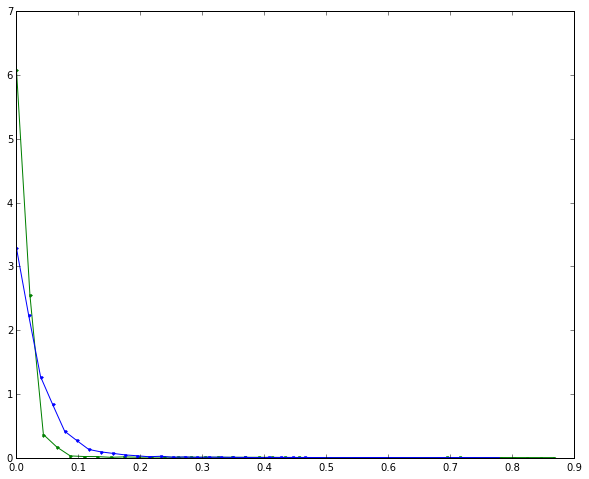

In [89]:
# get raw spatial projective fields
horz_spatial_pfs = get_horizontal_projective_field()
ama_spatial_pfs  = get_amacrine_projective_field()

# align the spatial projective fields
horz_x, horz_mean_pf, horz_err = get_mean(horz_spatial_pfs, nPoints=80)
ama_x, ama_mean_pf, ama_err    = get_mean(ama_spatial_pfs, nPoints=80)

horz_fft = get_fft([(horz_x, horz_mean_pf)], mode='amplitude')
ama_fft  = get_fft([(ama_x, ama_mean_pf)], mode='amplitude')

for freq, ffti in horz_fft:
    plot(freq, ffti, 'g.-')
for freq, ffti in ama_fft:
    plot(freq, ffti, 'b.-')

# Compare ideal and experimental filters  
Note that even controlling for effective contrast, the magnitude of the images makes a huge difference on what the ideal filter is. This is because it changes the power spectrum by quite a bit, which in turn makes the input and output noise either more or less impactful. TO-DO: Compute true SNR from power spectra.

In [363]:
print 'Effective contrast of example image is %5.2f%%.' %(100.*np.std(patches[0])/np.mean(patches[0]))

Effective contrast of example image is 35.00%.


In [190]:
input_noise  = 0.0002
output_noise = 0.001
np.mean(originalSpectra**2 / (input_noise * originalSpectra**2 + output_noise))

6.2332743126512238

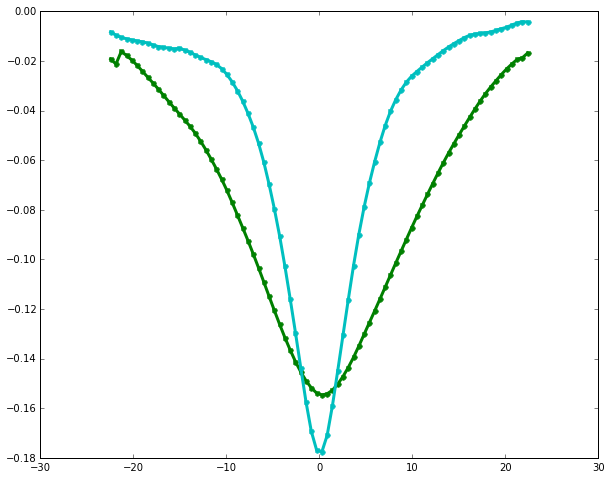

In [396]:
plot(space, horz_pf, 'g.-', linewidth=3, markersize=10)
plot(space, ama_pf, 'c.-', linewidth=3, markersize=10)

# Look at amplitude spectrum comparison

In [523]:
# get spatial rfs of bipolar and ganglion cells
bipolar_rfs  = load_bipolar_cells()
ganglion_rfs = load_ganglion_cells()

# compute ffts of bipolar and ganglion cells
bipolar_ffts  = get_fft(bipolar_rfs)
ganglion_ffts = get_fft(ganglion_rfs)

# get statistics on the ffts
bipolar_freq, bipolar_mean_fft, bipolar_sem    = get_mean(bipolar_ffts)
ganglion_freq, ganglion_mean_fft, ganglion_sem = get_mean(ganglion_ffts)

# get family of ideal filters
ideal_filts = {}
#input_noises  = np.logspace(-1.,-.42,10)
#output_noises = np.logspace(-.65,-.4,10)
# input_noises = [0.01, 0.05, 0.1, 0.15, 0.3, 0.4, 0.6]
# output_noises = [0.01, 0.05, 0.1, 0.15, 0.3, 0.4, 0.6]
input_noises = [0.085] #[0.12]
output_noises = [0.35] #[0.35]

moreFreqs, moreSpectra = spectrum_fit(originalFreqs, originalSpectra)
for N in input_noises:
    for N_del in output_noises:
        ideal_filts[(N,N_del)] = unique_soln(moreSpectra**2, N, N_del, verbose=False)

(0.085, 0.35)


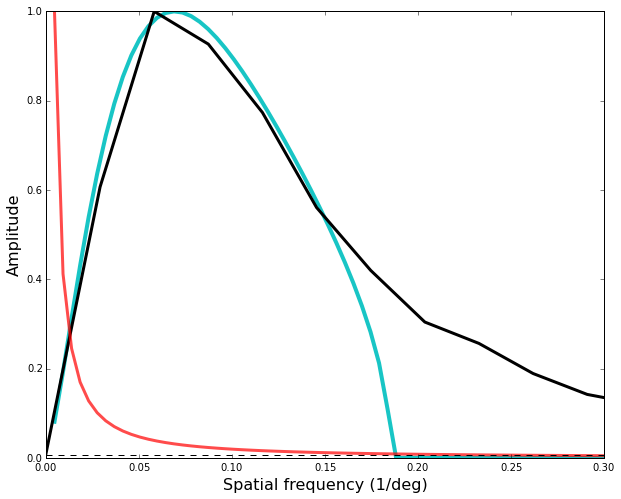

In [524]:
for k in ideal_filts.keys():
    plot(moreFreqs, (ideal_filts[k]/np.nanmax(ideal_filts[k])), 'c', alpha=0.9, linewidth=4) # alpha=0.6
    print k


g_max = np.nanmax(abs(mean_narrow_ganglion_fft))
plot(mean_narrow_freqs, abs(mean_narrow_ganglion_fft)/g_max, 'k', alpha=1., linewidth=3)
#errorbar(ganglion_freq, ganglion_mean_fft/g_max, yerr=(1./g_max)*ganglion_sem, color='k', alpha=0.7)

def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

numPoints=5000
popt, pcov  = curve_fit(func, originalFreqs[1:], originalSpectra[1:])
moreFreqs   = np.linspace(0., originalFreqs[-1], numPoints)[1:]
moreSpectra = func(moreFreqs, *popt)

plot(moreFreqs, (moreSpectra/np.nanmax(moreSpectra)), 'r', linewidth=3, alpha=0.7)
plot(originalFreqs, 0.085**2 *np.ones(len(originalFreqs)), 'k--')

ylabel('Amplitude', fontsize=16)
xlabel('Spatial frequency (1/deg)', fontsize=16)
xlim([0,.3])

# savefig('Figures/' + str(ideal_filts.keys()[n]) + '.png')
savefig('Figures/' + str(ideal_filts[k]) + '.png')
#     plt.close()
#     pause(2)
    #ylim([0,4])
    #mpld3.display()

# Look at power spectrum; why does power spectrum of infomax match the amplitude spectrum of ganglion cells better?

In [525]:
# get spatial rfs of bipolar and ganglion cells
bipolar_rfs  = load_bipolar_cells()
ganglion_rfs = load_ganglion_cells()

# compute ffts of bipolar and ganglion cells
bipolar_ffts  = get_fft(bipolar_rfs)
ganglion_ffts = get_fft(ganglion_rfs)

# get statistics on the ffts
bipolar_freq, bipolar_mean_fft, bipolar_sem    = get_mean(bipolar_ffts)
ganglion_freq, ganglion_mean_fft, ganglion_sem = get_mean(ganglion_ffts)

# get family of ideal filters
ideal_filts = {}
#input_noises  = np.logspace(-1.,-.42,10)
#output_noises = np.logspace(-.65,-.4,10)
# input_noises = [0.01, 0.05, 0.1, 0.15, 0.3, 0.4, 0.6]
# output_noises = [0.01, 0.05, 0.1, 0.15, 0.3, 0.4, 0.6]
input_noises = [0.11] #[0.085] #[0.12]
output_noises = [0.09] #[0.35] #[0.35]

moreFreqs, moreSpectra = spectrum_fit(originalFreqs, originalSpectra)
for N in input_noises:
    for N_del in output_noises:
        ideal_filts[(N,N_del)] = unique_soln(moreSpectra**2, N, N_del, verbose=False)

(0.11, 0.09)


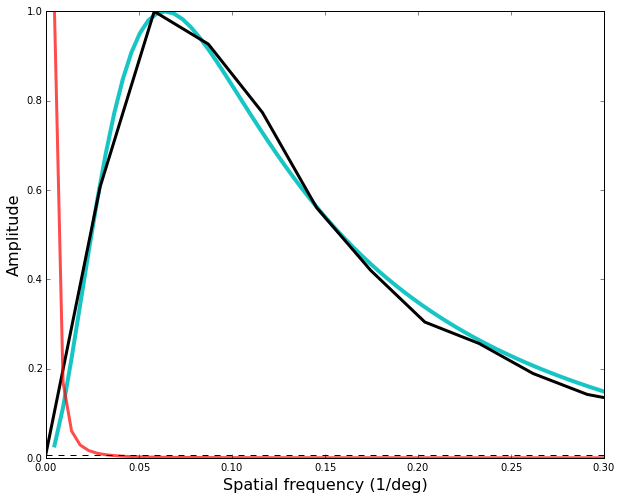

In [526]:
for k in ideal_filts.keys():
    plot(moreFreqs, (ideal_filts[k]/np.nanmax(ideal_filts[k]))**2, 'c', alpha=0.9, linewidth=4) # alpha=0.6
    print k


g_max = np.nanmax(abs(mean_narrow_ganglion_fft))
plot(mean_narrow_freqs, abs(mean_narrow_ganglion_fft)/g_max, 'k', alpha=1., linewidth=3)
#errorbar(ganglion_freq, ganglion_mean_fft/g_max, yerr=(1./g_max)*ganglion_sem, color='k', alpha=0.7)

def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

numPoints=5000
popt, pcov  = curve_fit(func, originalFreqs[1:], originalSpectra[1:])
moreFreqs   = np.linspace(0., originalFreqs[-1], numPoints)[1:]
moreSpectra = func(moreFreqs, *popt)

plot(moreFreqs, (moreSpectra/np.nanmax(moreSpectra))**2, 'r', linewidth=3, alpha=0.7)
plot(originalFreqs, 0.085**2 *np.ones(len(originalFreqs)), 'k--')

ylabel('Amplitude', fontsize=16)
xlabel('Spatial frequency (1/deg)', fontsize=16)
xlim([0,.3])

# savefig('Figures/' + str(ideal_filts.keys()[n]) + '.png')
savefig('Figures/' + str(ideal_filts[k]) + '.png')
#     plt.close()
#     pause(2)
    #ylim([0,4])
    #mpld3.display()

# Correct power vs power

In [539]:
# get spatial rfs of bipolar and ganglion cells
bipolar_rfs  = load_bipolar_cells()
ganglion_rfs = load_ganglion_cells()

# compute ffts of bipolar and ganglion cells
bipolar_ffts  = get_fft(bipolar_rfs)
ganglion_ffts = get_fft(ganglion_rfs)

# get statistics on the ffts
bipolar_freq, bipolar_mean_fft, bipolar_sem    = get_mean(bipolar_ffts)
ganglion_freq, ganglion_mean_fft, ganglion_sem = get_mean(ganglion_ffts)

# get family of ideal filters
ideal_filts = {}
#input_noises  = np.logspace(-1.,-.42,10)
#output_noises = np.logspace(-.65,-.4,10)
# input_noises = [0.01, 0.05, 0.1, 0.15, 0.3, 0.4, 0.6]
# output_noises = [0.01, 0.05, 0.1, 0.15, 0.3, 0.4, 0.6]
input_noises = [0.09] #[0.085] #[0.12]
output_noises = [0.35] #[0.35] #[0.35]

moreFreqs, moreSpectra = spectrum_fit(originalFreqs, originalSpectra)
for N in input_noises:
    for N_del in output_noises:
        ideal_filts[(N,N_del)] = unique_soln(moreSpectra**2, N, N_del, verbose=False)

In [580]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

(0.09, 0.35)


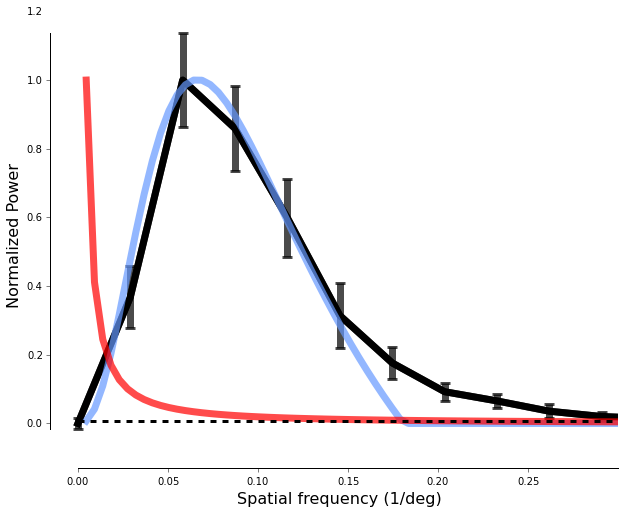

In [583]:
g_max = np.nanmax(abs(mean_narrow_ganglion_fft))
plot(mean_narrow_freqs, (abs(mean_narrow_ganglion_fft)/g_max)**2, 'k', alpha=1., linewidth=7)
narrow_ganglion_fft_errs = sem([(y/g_max)**2 for x, y in narrow_ganglions_ffts])
errorbar(mean_narrow_freqs, (abs(mean_narrow_ganglion_fft)/g_max)**2, yerr=narrow_ganglion_fft_errs, color='k', alpha=0.7, linewidth=7, capthick=3, capsize=5)

for k in ideal_filts.keys():
    plot(moreFreqs, (ideal_filts[k]/np.nanmax(ideal_filts[k]))**2, color='#6699ff', alpha=0.7, linewidth=7) # alpha=0.6
    print k

def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

numPoints=5000
popt, pcov  = curve_fit(func, originalFreqs[1:], originalSpectra[1:])
moreFreqs   = np.linspace(0., originalFreqs[-1], numPoints)[1:]
moreSpectra = func(moreFreqs, *popt)

plot(moreFreqs, (moreSpectra/np.nanmax(moreSpectra)), 'r', linewidth=7, alpha=0.7)
plot(originalFreqs, (0.085**2 *np.ones(len(originalFreqs))), 'k--', linewidth=3)

ylabel('Normalized Power', fontsize=16)
xlabel('Spatial frequency (1/deg)', fontsize=16)
xlim([-.01,.3])
ylim([-.1, 1.2])

tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(gca(), ['left', 'bottom'])

# savefig('Figures/' + str(ideal_filts.keys()[n]) + '.png')
savefig('Figures/' + str(ideal_filts[k]) + '.png')
#     plt.close()
#     pause(2)
    #ylim([0,4])
    #mpld3.display()

In [456]:
test1 = [-i*np.sign(2*(idx % 2) - 1) for idx,i in enumerate(ideal_filts[k])]
test2 = [i for i in ideal_filts[k]]

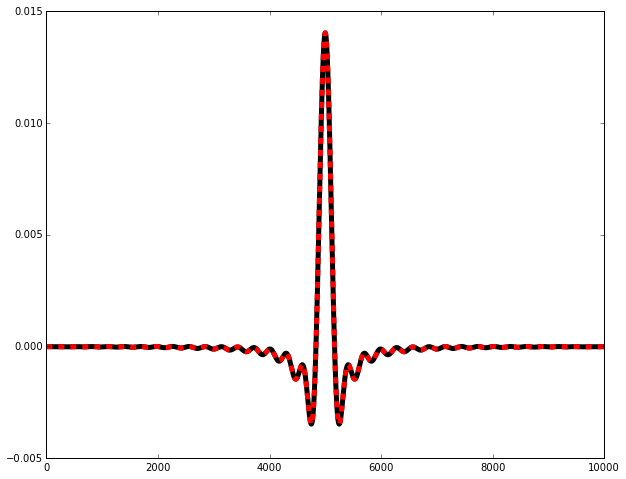

In [465]:
plot(np.fft.ifft(np.hstack([test1, test1[1:][::-1]])), 'k', linewidth=5)
plot(np.fft.fftshift(np.fft.ifft(np.hstack([test2, test2[1:][::-1]]))), 'r--', linewidth=5)

In [ ]:
plot(np.fft.ifft(np.hstack([test1, test1[1:][::-1]])), 'k', linewidth=5)
plot(np.fft.fftshift(np.fft.ifft(np.hstack([test2, test2[1:][::-1]]))), 'r--', linewidth=5)

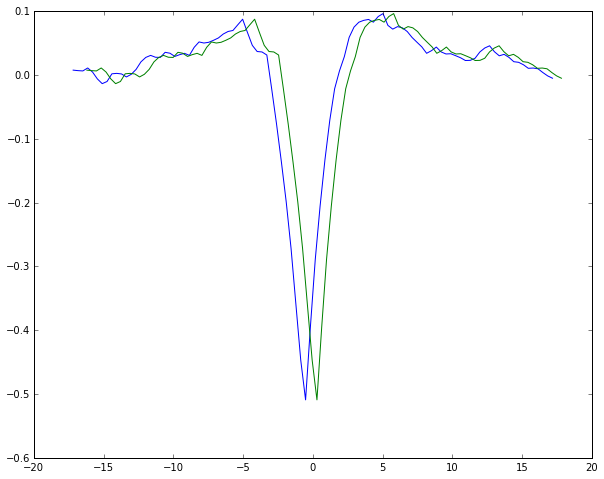

In [605]:
# spacing_valid = valid_space[-1] - valid_space[-2]
spacing_valid = 1./(2*mean_narrow_freqs[-1])
n = len(valid_space)
symm_spacing = np.linspace(-spacing_valid*(n/2),spacing_valid*(n/2),n)

plot(symm_spacing, np.mean(narrow_ganglions, axis=0))
plot(valid_space, np.mean(narrow_ganglions, axis=0), 'g')

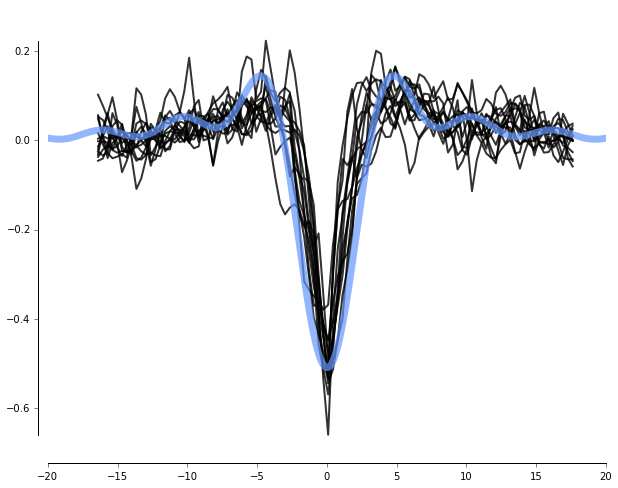

In [631]:
# Experimental
#plot(valid_space, np.mean(narrow_ganglions, axis=0), color='k', alpha=0.8, linewidth=7)
plot(valid_space-.2, narrow_ganglions.T, color='k', alpha=0.8, linewidth=2)
#errorbar(valid_space-.2, np.mean(narrow_ganglions, axis=0), yerr=sem(narrow_ganglions), color='k', alpha=0.7, linewidth=7, capthick=3, capsize=5)

# IDEAL
spacing_ideal = 1./(2*moreFreqs[-1])
filter_ideal  = np.fft.ifftshift(np.fft.ifft(np.hstack([ideal_filts[k], ideal_filts[k][1:][::-1]])))
n             = len(filter_ideal)
filter_x      = np.linspace(-spacing_ideal*n/2., spacing_ideal*n/2., n)
filter_ideal *= -(np.max(abs(np.mean(narrow_ganglions, axis=0)))/np.max(abs(filter_ideal)))
plot(filter_x, filter_ideal, color='#6699ff', alpha=0.7, linewidth=7)
xlim([-20,20])

tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(gca(), ['left', 'bottom'])